In [19]:
import pandas as pd
import matplotlib.pyplot as plt

STEP 1 and 2: Extract data from the following datasets:
1/ VDEM Institute's GitHub which takes polyarchical data per country on a yearly basis.
2/ International Monetary Fund (IMF), specifically the World Economic Outlook. This looks at GDP across all time for any selected country. This also comes from a CSV source, unlike dataset 1.

In [20]:
# 1/ Extract the VDEM Institute Polyarchy data, and specifically select South Korea and Taiwan data:
url = "https://raw.githubusercontent.com/vdeminstitute/ERT/refs/heads/master/inst/ert.csv"
#df = pd.read_csv(url)

df = pd.read_csv(url)

selected_rows = df[df['country_name'].isin (['South Korea', 'Taiwan'])]  # Extracting only the data where country_name == South Korea or Taiwan
print(selected_rows)

country_polyarchy_sum = selected_rows.groupby(['country_name','year'])['v2x_polyarchy'].sum().reset_index()

country_polyarchy_sum

      Unnamed: 0  country_id country_text_id country_name  year  v2x_regime  \
4164        4165          42             KOR  South Korea  1900         0.0   
4165        4166          42             KOR  South Korea  1901         0.0   
4166        4167          42             KOR  South Korea  1902         0.0   
4167        4168          42             KOR  South Korea  1903         0.0   
4168        4169          42             KOR  South Korea  1904         0.0   
...          ...         ...             ...          ...   ...         ...   
4889        4890          48             TWN       Taiwan  2020         3.0   
4890        4891          48             TWN       Taiwan  2021         3.0   
4891        4892          48             TWN       Taiwan  2022         3.0   
4892        4893          48             TWN       Taiwan  2023         3.0   
4893        4894          48             TWN       Taiwan  2024         3.0   

      v2x_polyarchy  v2x_polyarchy_codelow  v2x_pol

,country_name,year,v2x_polyarchy
0,South Korea,1900,0.028
1,South Korea,1901,0.028
2,South Korea,1902,0.028
3,South Korea,1903,0.028
4,South Korea,1904,0.021
...,...,...,...
245,Taiwan,2020,0.824
246,Taiwan,2021,0.824
247,Taiwan,2022,0.827
248,Taiwan,2023,0.823


In [21]:
# Step 2: Extract the data from IMF, specifically the World Economic Outlook (WEO) dataset. Here, I look at the GDP across all time for the 'Republic of Korea' and the 'Taiwan Province of China' (as per the naming conventions in the IMF dataset):
imf_read = 'C:/Users/lukep/Desktop/Semester - S1/Data Science for Public Policy/Python/dataset_2025-04-26T04_37_57.623941047Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv'
imf_df = pd.read_csv(imf_read)

imf_long = imf_df.melt(
    id_vars=['COUNTRY'],
    var_name = 'year',
    value_name = 'gdp'
)

# Load the CSV normally
imf_df = pd.read_csv(imf_read)

# Melt the dataframe
imf_long = imf_df.melt(
    id_vars=['COUNTRY'],
    var_name='year',
    value_name='gdp'
)

# Convert  invalid years in NULLs:
imf_long['year'] = pd.to_numeric(imf_long['year'], errors='coerce')

# Remove NULLs
imf_long = imf_long.dropna(subset=['year'])

# Converting year from a string to an int:
imf_long['year'] = imf_long['year'].astype(int)

# Output results:
imf_long

,COUNTRY,year,gdp
12,"Korea, Republic of",1980,188693.1
13,Taiwan Province of China,1980,2346.027
14,"Korea, Republic of",1981,202663.5
15,Taiwan Province of China,1981,2568.255
16,"Korea, Republic of",1982,219825.8
...,...,...,...
109,Taiwan Province of China,2028,26020.456
110,"Korea, Republic of",2029,2492977.417
111,Taiwan Province of China,2029,26603.117
112,"Korea, Republic of",2030,2538853.479


STEP 3: Change the country names for dataset 2 to align with dataset 1's country names. 
Then, both datasets will merge into on singular dataset.

In [22]:
#Step 3: Since the country names differ between datasets, I shall align them to their commonly used conventions: 'South Korea' and 'Taiwan':
imf_long['COUNTRY'] = imf_long['COUNTRY'].replace({
    'Korea, Republic of': 'South Korea',
    'Taiwan Province of China': 'Taiwan'
})

join_df = pd.merge(
    country_polyarchy_sum,
    imf_long,
    left_on=['country_name', 'year'],
    right_on=['COUNTRY', 'year']
)
join_df = join_df.drop(columns = 'COUNTRY')

join_df
#imf_long
#imf_df
#country_polyarchy_mean
#df

,country_name,year,v2x_polyarchy,gdp
0,South Korea,1980,0.202,188693.1
1,South Korea,1981,0.210,202663.5
2,South Korea,1982,0.222,219825.8
3,South Korea,1983,0.228,249429.2
4,South Korea,1984,0.244,275960.1
...,...,...,...,...
85,Taiwan,2020,0.824,20402.197
86,Taiwan,2021,0.824,21773.291
87,Taiwan,2022,0.827,22357.584
88,Taiwan,2023,0.823,22608.347


STEP 4: Descriptive statistics. Below, I will create some simple statistics, mainly SUM, MEAN, MIN and MAX over all years. I shall do the same for decades also to determine for each country, which year and decade had the best and worst perfomance regarding GDP and polyarchy:

In [23]:
# Initialize a dictionary to hold the summaries
summary_dict = {}

# Loop over each country separately
for country in join_df['country_name'].dropna().unique():
    country_df = join_df[join_df['country_name'] == country].dropna(subset=['gdp', 'v2x_polyarchy'])

    if not country_df.empty:
        # Highest and lowest GDP
        max_gdp_row = country_df.loc[country_df['gdp'].idxmax()]
        min_gdp_row = country_df.loc[country_df['gdp'].idxmin()]
        
        # Highest and lowest Polyarchy
        max_polyarchy_row = country_df.loc[country_df['v2x_polyarchy'].idxmax()]
        min_polyarchy_row = country_df.loc[country_df['v2x_polyarchy'].idxmin()]
        
        # Create decade column
        country_df = country_df.assign(decade=(country_df['year'] // 10) * 10)
        
        # Group by decade
        gdp_decade_stats = country_df.groupby('decade')['gdp'].agg(['sum', 'mean']).reset_index()
        
        # Best and worst decades
        best_decade_row = gdp_decade_stats.loc[gdp_decade_stats['sum'].idxmax()]
        worst_decade_row = gdp_decade_stats.loc[gdp_decade_stats['sum'].idxmin()]
        
        # Add the results into the dictionary
        summary_dict[country] = [
            f"{int(max_gdp_row['year'])} ({max_gdp_row['gdp']:.2f})",
            f"{int(min_gdp_row['year'])} ({min_gdp_row['gdp']:.2f})",
            f"{int(max_polyarchy_row['year'])} ({max_polyarchy_row['v2x_polyarchy']:.2f})",
            f"{int(min_polyarchy_row['year'])} ({min_polyarchy_row['v2x_polyarchy']:.2f})",
            f"{int(best_decade_row['decade'])}s (Total GDP: {best_decade_row['sum']:.2f})",
            f"{int(worst_decade_row['decade'])}s (Total GDP: {worst_decade_row['sum']:.2f})"
        ]

# Now construct the final table
summary_table_pivot = pd.DataFrame({
    "Metric": [
        "Year with Highest GDP",
        "Year with Lowest GDP",
        "Year with Highest Polyarchy",
        "Year with Lowest Polyarchy",
        "Best Decade (by GDP Total)",
        "Worst Decade (by GDP Total)"
    ]
})

# Dynamically add each country as a column
for country, summary_list in summary_dict.items():
    summary_table_pivot[country] = summary_list

# Display
summary_table_pivot


,Metric,South Korea,Taiwan
0,Year with Highest GDP,2024 (2288648.70),2024 (23580.39)
1,Year with Lowest GDP,1980 (188693.10),1980 (2346.03)
2,Year with Highest Polyarchy,2018 (0.86),2018 (0.84)
3,Year with Lowest Polyarchy,1980 (0.20),1980 (0.13)
4,Best Decade (by GDP Total),2010s (Total GDP: 18211582.70),2010s (Total GDP: 173955.64)
5,Worst Decade (by GDP Total),1980s (Total GDP: 3012535.20),1980s (Total GDP: 34781.95)


STEP 5: Finally, I created a chart showing the change in polyarchy and GDP for both South Korea and Taiwan over time. As you can see, both countries saw a huge rise in polyarchical factors (the right to vote, freedom of expression, right of political leaders to compete for support etc.) for both countries. First South Korea during the 80s, and Taiwan in the 90s. However, we can see that in recent years, polyarchy for both states has started a downward tilt, especially South Korea. One reason for this could be South Korea's stripping of voting rights for foreigners in 2022.

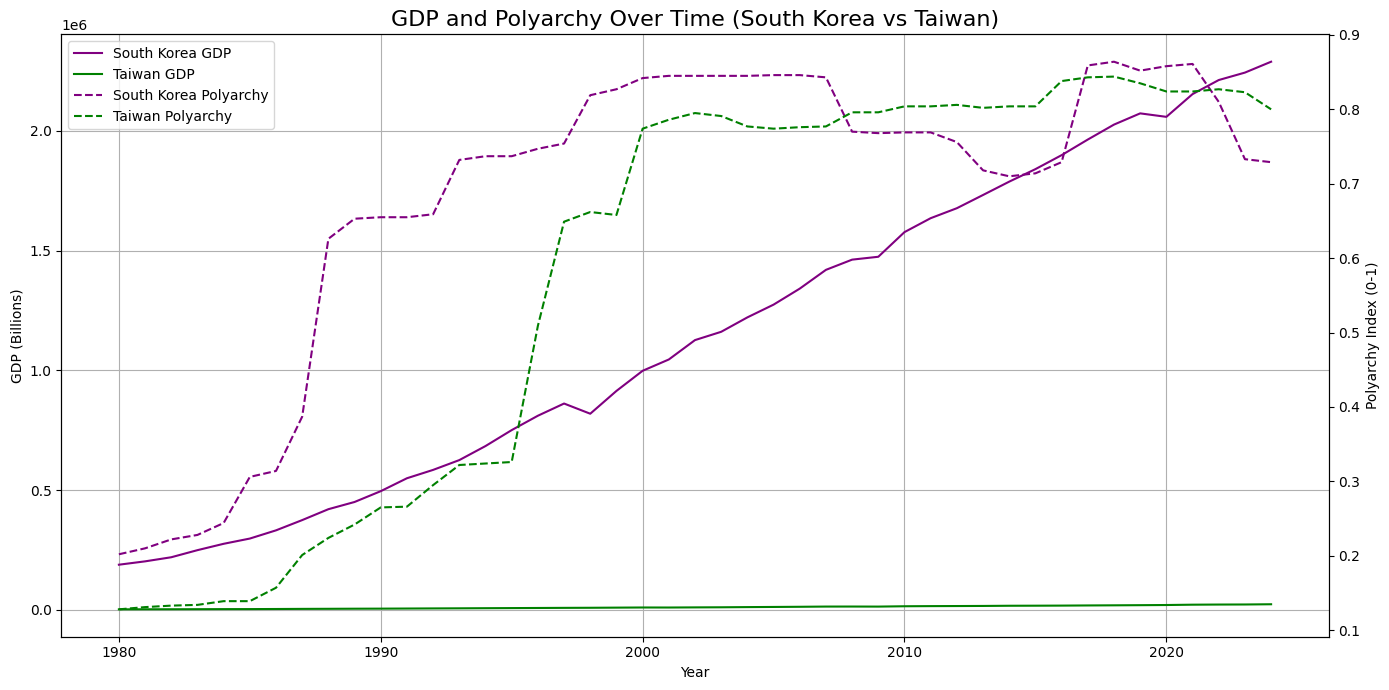

In [ ]:
# Set up the figure:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot GDP on the left y-axis:
colors = {'South Korea': 'purple', 'Taiwan': 'green'}

for country in join_df['country_name'].unique():
    country_data = join_df[join_df['country_name'] == country]
    ax1.plot(
        country_data['year'],
        country_data['gdp'],
        label=f'{country} GDP',
        color=colors[country],
        linestyle='-'
    )

ax1.set_xlabel('Year')
ax1.set_ylabel('GDP (Billions)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis:
ax2 = ax1.twinx()

# Plot Polyarchy on the right y-axis:
for country in join_df['country_name'].unique():
    country_data = join_df[join_df['country_name'] == country]
    ax2.plot(
        country_data['year'],
        country_data['v2x_polyarchy'],
        label=f'{country} Polyarchy',
        color=colors[country],
        linestyle='--'
    )

ax2.set_ylabel('Polyarchy Index (0-1)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title:
plt.title('GDP and Polyarchy Over Time (South Korea vs Taiwan)', fontsize=16)

# Combine legends from both y-axesL
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left')

# Grid and final layout:
ax1.grid(True)
plt.tight_layout()
plt.show()
